In [1]:
%load_ext Cython

In [2]:
%%cython

from __future__ import division
import numpy as np
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half, nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
            for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector

In [3]:
# imports
import numpy as np
import os
import glob
from astropy.io import fits
from astropy.io.fits import getdata
from astropy.stats import mad_std
from photutils import DAOStarFinder
import time
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.stats import norm
from scipy.ndimage.interpolation import shift
import PyTorchDIA_Newton
import torch
%matplotlib inline

PyTorch version: 1.5.1


In [4]:
## Specify all the functions required ##

def extend_image(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + 2 * kernel_size,
                             np.shape(image)[1] + 2 * kernel_size))
    image_extended[kernel_size:-kernel_size, kernel_size:-kernel_size] = np.array(image, float)
    
    return image_extended

# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel


def save_numpy_as_fits(numpy_array, filename):
    hdu = fits.PrimaryHDU(numpy_array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)
    

Reference FWHM: 5.625057500773691
Reference shape: (512, 512)


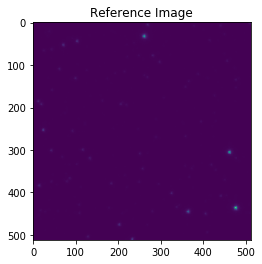

In [5]:
## path to images
path = 'OGLE-III-BLG101'

## reference image
ref_file = os.path.join(path, 'coll_OGLE-III-BLG101_Llr_2019-07-20_00048.fits')
ref_data = getdata(ref_file, header=True)
ref, ref_fwhm = ref_data[0], ref_data[1]['FWHM']
shape = ref.shape
print('Reference FWHM:', ref_fwhm)
print('Reference shape:', shape)

plt.title('Reference Image')
plt.imshow(ref)

Number of bright detected sources: 232


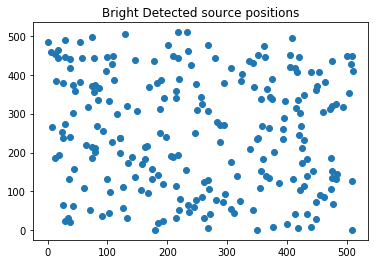

Number of bright (separated) detected sources: 232


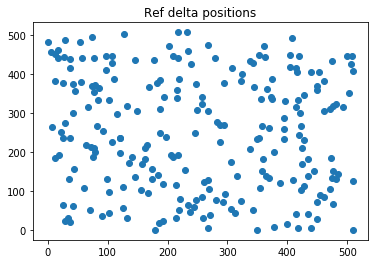

DBFs in ref_delta: 232


In [6]:
## bright stars for PSF inference
## find bright star peaks above given threshold (sky subtract)
sky, std = np.median(ref), mad_std(ref)
thrs = 5
daofind_bright = DAOStarFinder(fwhm=ref_fwhm, threshold=thrs*std)  
sources_bright = daofind_bright(ref - sky)

ref_delta_positions = np.transpose((sources_bright['xcentroid'], sources_bright['ycentroid'],
                                    sources_bright['peak']))

print('Number of bright detected sources:', len(ref_delta_positions))

plt.title('Bright Detected source positions')
plt.scatter(ref_delta_positions[:,0], ref_delta_positions[:,1])
plt.show()

min_sep = 0
seps = []
mask = np.zeros(len(ref_delta_positions))

for i,pos1 in enumerate(ref_delta_positions):
    for j,pos2 in enumerate(ref_delta_positions):
        sep_x = np.abs(pos1[0] -  pos2[0])
        sep_y = np.abs(pos1[1] -  pos2[1])
        sep = np.sqrt(sep_x**2 + sep_y**2)
        if sep !=0 and sep not in seps and mask[j] != 1:
            seps.append(sep)
            if sep < min_sep:
                mask[i] = 1
                break

# delta function positions
dbf_x = ref_delta_positions[:,0][mask == 0].astype(int)
dbf_y = ref_delta_positions[:,1][mask == 0].astype(int)
#bright_peaks = ref_delta_positions[:,2][mask == 0].astype(int)
# check
print('Number of bright (separated) detected sources:', len(dbf_x))

# well distributed across image?
plt.title('Ref delta positions')
plt.scatter(dbf_x, dbf_y)
plt.show()


# mask non peak positions
mask_image = np.ones(shape)
# peaks
mask_image[dbf_y, dbf_x] = 0

ref_delta = np.copy(ref)
# apply mask
ref_delta[mask_image == 1] = 0.
#ref_delta[mask_image == 0] = 1.


# check
print('DBFs in ref_delta:', len(np.where(ref_delta!=0)[0]))

Detected 232 sources:


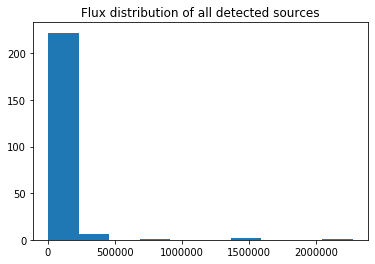

(232, 4)
(115, 4)
115 possible sources for the photometry:


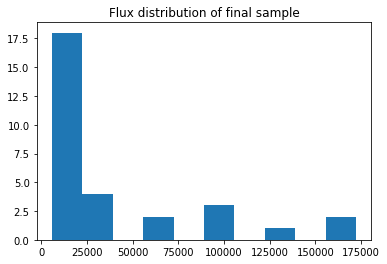

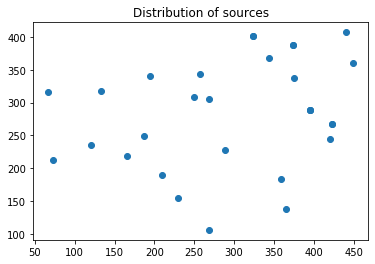

Using 30 sources to assess photometric accuracy.


In [7]:
# generate random list of stars for photometry

daofind = DAOStarFinder(fwhm=ref_fwhm, threshold=5.*std)  
sources = daofind_bright(ref - sky)


print('Detected %d sources:' % len(sources))
plt.title('Flux distribution of all detected sources')
plt.hist(sources['peak'])
plt.show()

#cut = 0
#peak_lower_bound = np.percentile(sources['peak'], cut)
#sources = sources[np.where(sources['peak']>peak_lower_bound)]
#print('Number of sources after removing %d percent faintest detected sources: %d' % (cut, len(sources)))
#plt.hist(sources['peak'])
#plt.show()

# extract positions, and avoid images edges (half reference-image pair size boundary)
positions = np.transpose((sources['xcentroid'], sources['ycentroid'], sources['id'], sources['peak']))
positions = positions.astype(int)
print(positions.shape)
positions = positions[np.where(positions[:,0] > 50)]
positions = positions[np.where(positions[:,0] < ref.shape[0] - 50)]
positions = positions[np.where(positions[:,1] > 100)]
positions = positions[np.where(positions[:,1] < ref.shape[1] - 100)]
print(positions.shape)


print('%d possible sources for the photometry:' % len(positions))

# measure light curves of nsources = 30
np.random.seed(84)
nsources = 30
rand_sources = np.random.randint(0, len(positions), nsources)
positions = positions[rand_sources]

plt.title('Flux distribution of final sample')
plt.hist(positions[:,3])
plt.show()


# uniformly distributed??
plt.title('Distribution of sources')
plt.scatter(positions[:,0], positions[:,1])
plt.show()

print('Using %d sources to assess photometric accuracy.' % len(positions))

['2019-07-21', '2019-07-28', '2019-07-27', '2019-07-20', '2019-07-30', '2019-07-26', '2019-07-29', '2019-07-24', '2019-07-17', '2019-07-25', '2019-07-18', '2019-07-19']
(512, 512) (263, 512, 512) (12, 512, 512)
Median FWHM: 8.681087186520154


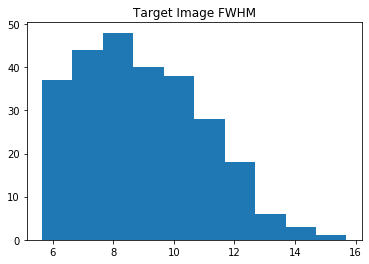

In [8]:
## master flat
#path = 'LOB190560Z'

#flat_file = os.path.join(path, 'master_flat.fits')
#master_flat = getdata(flat_file, 0, header=True)[0]

## shifts
shift_info = os.path.join(path, 'Shift_info.txt')
shifts = np.genfromtxt(shift_info, delimiter="\t", dtype=str) # filename | xs | ys

## crop reference and master flat ##
crop = 0
ref = ref[crop:ref.shape[0]-crop, crop:ref.shape[1]-crop]
#master_flat = master_flat[crop:master_flat.shape[0]-crop, crop:master_flat.shape[1]-crop]

# and crop ref_delta
ref_delta = ref_delta[crop:ref_delta.shape[0]-crop, crop:ref_delta.shape[1]-crop]

## ensure dtype=np.float32
ref = np.array(ref, dtype=np.float32)
#master_flat = np.array(master_flat, dtype=np.float32)

fnames = []
images = []
FWHMs = []
Tot_ims = []

for image_file in glob.glob(os.path.join(path, "*coll*")):
    #print(image_file)
    # avoid reference
    if ref_file not in image_file and '2019-07-28_00000.fits' not in image_file:
        fnames.append(image_file.split('/')[-1])
        #print(image_file.split('/')[-1])
        image_data = getdata(image_file, header=True)
        image, header = image_data[0], image_data[1]
        image = image[crop:image.shape[0]-crop, crop:image.shape[1]-crop]
        ## apply any crops to image border ##
        images.append(image)
        FWHMs.append(header['FWHM'])
        Tot_ims.append(header['TOT_IM'])
        

# flats
master_flats = []
master_flat_dates = []
for image_file in glob.glob(os.path.join(path, "Master_flats_OGLE-III-BLG101/*.fits")):
    master_flat_dates.append(image_file.split('_')[-1].split('.')[0])
    image_data = getdata(image_file, header=True)
    image, header = image_data[0], image_data[1]
    image = image[crop:image.shape[0]-crop, crop:image.shape[1]-crop]    
    master_flats.append(image)


# convert to numpy arrays (float32)
images, FWHMs, Tot_ims = np.array(images, dtype=np.float32), np.array(FWHMs), np.array(Tot_ims, dtype=np.int)
master_flats = np.array(master_flats, dtype=np.float32)

print(master_flat_dates)

print(ref.shape, images.shape, master_flats.shape)

# distribution of FWHMs
plt.figure()
plt.hist(FWHMs)
plt.title('Target Image FWHM')
print('Median FWHM:', np.median(FWHMs))

In [1]:
## run this cell once to load gpu, then run again for actual test
## gpu overhead associated with first loading it will screw with the
## actual solutiontimes for the very first image

# define function to return fit quality metrics
def metrics(M, I, noise_map, kernel_size, mask):
    
    # crop image edges to exlcude convolution artefacts
    M = M[kernel_size:M.shape[0]-kernel_size, kernel_size:M.shape[1]-kernel_size]
    I = I[kernel_size:I.shape[0]-kernel_size, kernel_size:I.shape[1]-kernel_size]
    noise_map = noise_map[kernel_size:noise_map.shape[0]-kernel_size, kernel_size:noise_map.shape[1]-kernel_size]
    mask = mask[kernel_size:mask.shape[0]-kernel_size, kernel_size:mask.shape[1]-kernel_size]
    
    # calculate metrics
    #x[~np.array(mask)]
    N_data = len(I[mask == 0].flatten())
    MFB = 1./(N_data) * np.sum((I - M)/noise_map)
    MFV = 1./(N_data - 1) * np.sum((((I - M)/noise_map) - MFB)**2)
    return MFB, MFV

# cutout stamp around position of selected stars
def make_stamp(image, pos, stamp_size):
    rad = np.int(stamp_size/2)
    x_centroid, y_centroid = pos[1], pos[0]
    x_max, x_min = x_centroid + rad, x_centroid - rad
    y_max, y_min = y_centroid + rad, y_centroid - rad
    stamp = image[x_min:x_max+1, y_min:y_max+1]
    return stamp

# cutout stamp around position of selected stars
def make_fit_cutout(image_stamp, c_size):
    centre = np.int(image_stamp.shape[0]/2)
    radius = np.int((c_size/2))
    cutout = image_stamp[centre - radius:centre + radius + 1, centre - radius:centre + radius + 1]
    return cutout

## sky subtract reference
ref -= np.median(ref)

## iterate through target images

#target_size = 100

times_to_kernel_solution = []
total_times = []
image_FWHMs = []
image_SNRs = []
MFBs = []
MFVs = []
Ps_normalised = []
B0s = []
norm_phot_resids = []
stamp_ids = []


start_time = time.time()

for i, image in enumerate(images):
    
    #out = np.vstack((MFBs, MFVs, Ps_normalised, np.array(norm_phot_resids).flatten(),
    #                 image_SNRs, image_FWHMs, stamp_ids)).T
    
    image_FWHMs = []
    image_SNRs = []
    MFBs = []
    MFVs = []
    Ps_normalised = []
    norm_phot_resids = []
    stamp_ids = []

    print('Image %d of %d' % (i, len(images)))
    print('Consisting of %d frames' % Tot_ims[i])
    
    # load corresponding flat
    name = fnames[i]
    print(name)
    date = name.split('_')[3]
    flat_index = np.where(np.array(master_flat_dates) == date)[0][0]
    print('Using flat:', master_flat_dates[flat_index])
    master_flat = master_flats[flat_index]
    
    fwhm = FWHMs[i]
    print('Image FWHM:', fwhm)
    # stamp radius is 1 fwhm
    ss = np.int(2*fwhm)
    if ss % 2 == 0:
        ss += 1

    print('Stamp size:', ss)

    file_name = fnames[i]
    ys, xs = shifts[:,1][np.where(shifts[:,0] == file_name)][0], shifts[:,2][np.where(shifts[:,0] == file_name)][0]
    
    # x and y switched
    shiftxy = np.array([xs.astype(int), ys.astype(int)])
    
    #print('Aligning flat with (xs, ys) shifts:',xs.astype(int), ys.astype(int))
    # shift flat and delta function scene to target image
    #flat = shift(master_flat, (ys.astype(int),xs.astype(int)), cval=0.)

    # store values for photometric accuracy metrics
    # requires relative P for P_true
    photometric_scale_factors = []
    F_measured_values = []
    target_psf_objects = []
    pixel_uncertanties_list = []
         

    ## for each image, divide this into image and reference stamps centered on a star ##
    ## solve a kernel and background term for each, and perform psf fitting at the    ##
    ## position of the star in the difference image.
    for j,pos in enumerate(positions[:, [0,1]]):
        
        try:
        
            if 50 < pos[0] < image.shape[0] - 50 and 100 < pos[1] < image.shape[1] - 100:
                # add shifts to positions to we get the right part of the reference and flat
                print('Ref position:', pos)
                print('Shift:', shiftxy)
                cutout_size = 100
                image_stamp = make_stamp(image, pos + shiftxy, cutout_size)
                ref_stamp = make_stamp(ref, pos, cutout_size)
                flat_stamp = make_stamp(master_flat, pos + shiftxy, cutout_size)
                ref_delta_stamp = make_stamp(ref_delta, pos, cutout_size)
                
                mask = np.zeros(image_stamp.shape)
                for iters in range(0, 3):
                    
                    # pixel uncertanties
                    sigma0 = 2.55 # read noise
                    N = Tot_ims[i] # number of images
                    gain_CCD = 25.8 # CCD gain
                    gain_EM = 300. # EM gain
                    G = gain_CCD / gain_EM # Total gain
                    excess_noise_factor = 2 # EMCCD fudge factor
                    if iters == 0:
                        shot_noise = image_stamp/(G*flat_stamp)
                    else:
                        shot_noise = model/(G*flat_stamp)   
                    read_noise = N*sigma0**2 / flat_stamp**2
                    #var_model = excess_noise_factor*(shot_noise + read_noise)
                    
                    var_model = excess_noise_factor*shot_noise
                    pixel_uncertanties = np.sqrt(var_model) 
                    
                    # Noise Model
                    weights_stamp = 1./var_model
                    # mask outliers
                    weights_stamp[np.where(mask == 1)] = 1e-198
                    print('\nMasked pixels (pyDANDIA):', np.sum(mask))
                    print('\npyDANDIA solution, iter %d' % iters)
                    ext_ref = extend_image(ref_stamp, ss)
                    ext_imag = extend_image(image_stamp, ss)
                    ext_weights = extend_image(weights_stamp, ss)

                    U, b = construct_kernel_and_matrices(ss, ext_ref, ext_imag, ext_weights)
                    kernel, B0 = lstsq_solution(ext_ref, ext_imag, U, b, ss)
                    print('P:', np.sum(kernel))
                    print('B0:', B0)
                    model = convolve2d(ref_stamp, kernel, mode='same') + B0
                    print('weights_stamp shape:', weights_stamp.shape)
                    print('image_stamp shape:', image_stamp.shape)
                    print('model shape:', model.shape)
                    norm_resids = np.sqrt(weights_stamp)*(image_stamp - model)
                    mask[np.where(np.abs(norm_resids)>5)] = 1
                    
                    print('Sum abs(norm_resids):', np.sum(np.abs(norm_resids)))
                    
                    '''
                    plt.figure(figsize=(5,5))
                    plt.hist(norm_resids.flatten(), bins='auto', density=True)
                    #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
                    x = np.linspace(-5, 5, 100)
                    plt.plot(x, norm.pdf(x, 0, 1))
                    plt.xlim(-5, 5)
                    plt.xticks(fontsize=20)
                    plt.yticks(fontsize=20)
                    plt.xlabel('Normalised residuals', fontsize=20)
                    plt.ylabel('Probability', fontsize=20)
                    #plt.savefig(os.path.join(path, 'NormalisedResids.png'), bbox_inches='tight', overwrite=True)
                    plt.show()
                    '''


                # model image
                model = convolve2d(ref_stamp, kernel, mode='same') + B0
                
                bad_pixel_mask = mask

                

                #### PSF fitting photometry in difference image ####
                #### build median PSF model via jacknife approach ####

                psf, placeholder, placeholder, placeholder, placeholder = PyTorchDIA_Newton.DIA(ref_delta_stamp,
                                                                      image_stamp,
                                                                      flat_stamp, # flatfield
                                                                      read_noise = 0.,
                                                                      tot_im = Tot_ims[i],
                                                                      unweighted=True,
                                                                      n_samples=1,
                                                                      full_image=True,
                                                                      display_stamps=False, 
                                                                      sky_subtract = False,
                                                                      iters=3,
                                                                      ks = ss,
                                                                      lr_kernel = 1e-2,
                                                                      lr_B = 100,
                                                                      SD_steps = 0,
                                                                      Newton_tol = 1e-6,
                                                                      poly_degree=0,
                                                                      fast=True,
                                                                      tol = 1e-9,
                                                                      alpha = 0., 
                                                                      max_iterations = 5000,
                                                                      fisher=False,
                                                                      show_convergence_plots=False,
                                                                      display_D=False,
                                                                      k=1e99,
                                                                      precision=3,
                                                                      display_masked_stamps=False,
                                                                      display_M=False,
                                                                      display_kernel=False,
                                                                      display_B = False)

                #stop = input()
                psf /= np.sum(psf)

                # pixel uncertanties
                sigma0 = 2.55 # read noise
                #N = 1200 # number of images
                N = Tot_ims[i]
                gain_CCD = 25.8 # CCD gain
                gain_EM = 300. # EM gain
                G = gain_CCD / gain_EM # Total gain
                excess_noise_factor = 2 # EMCCD fudge factor
                shot_noise = model/(G*flat_stamp)
                read_noise = N*sigma0**2 / flat_stamp**2
                #var_model = excess_noise_factor*(shot_noise + read_noise)
                var_model = excess_noise_factor*shot_noise
                pixel_uncertanties = np.sqrt(var_model) # Noise Model


                stamp_fit = make_fit_cutout(image_stamp - model, ss)
                noise_stamp_fit = make_fit_cutout(pixel_uncertanties, ss)

                ## psf fit
                F_diff = torch.nn.Parameter(torch.ones(1), requires_grad=True)
                const = torch.nn.Parameter(torch.ones(1), requires_grad=True)
                print('Starting F_diff and const:', F_diff, const)

                #print(model.shape, stamp_fit.shape, noise_stamp_fit.shape)

                target_psf_object = torch.from_numpy(psf)
                stamp_fit = torch.from_numpy(np.array(stamp_fit, dtype=np.float32))
                noise_stamp_fit = torch.from_numpy(np.array(noise_stamp_fit, dtype=np.float32))

                class log_likelihood(torch.nn.Module):

                    def forward(model, stamp, noise_stamp):
                        #print(stamp.size(), model.size(), noise_stamp.size())
                        loglikelihood = -0.5*(((stamp - model)/noise_stamp)**2).sum()
                        return -loglikelihood

                optimizer = torch.optim.Adam([F_diff, const], lr=1000)

                tol = 1e-20
                losses = []
                for step in range(0, 150000):
                    optimizer.zero_grad()
                    psf_model = F_diff*target_psf_object + const
                    loss = log_likelihood.forward(psf_model, stamp_fit, noise_stamp_fit)
                    losses.append(loss.item())
                    loss.backward()
                    optimizer.step()

                    if step>1 and abs((losses[-1] - losses[-2])/losses[-2]) < tol:
                        print('Converged')
                        break


                print('Final F and const:', F_diff, const)
                #plt.plot(losses)

                ## convert tensors back to numpy arrays
                F_diff = F_diff.detach().numpy()
                const = const.detach().numpy()
                target_psf_object = target_psf_object.detach().numpy()
                stamp_fit = stamp_fit.detach().numpy()
                noise_stamp_fit = noise_stamp_fit.detach().numpy()

                ## Difference flux of brightest star
                F_measured = F_diff / np.sum(kernel)

                # store values to cal
                F_measured_values.append(F_measured)
                photometric_scale_factors.append(np.sum(kernel))
                target_psf_objects.append(target_psf_object)
                pixel_uncertanties_list.append(noise_stamp_fit)

                # stamp number
                stamp_ids.append(j)

                # image SNR
                sky = np.median(image_stamp)
                SNR = np.sum(image_stamp - sky) / np.sqrt(np.sum(pixel_uncertanties**2))
                image_SNRs.append(SNR)
                image_FWHMs.append(FWHMs[i])

                # bad pixel mask
                model = np.ma.array(model, mask=bad_pixel_mask)
                image_stamp = np.ma.array(image_stamp, mask=bad_pixel_mask)
                pixel_uncertanties = np.ma.array(pixel_uncertanties, mask=bad_pixel_mask)

                # metrics
                MFB, MFV = metrics(model, image_stamp, pixel_uncertanties, ss, bad_pixel_mask)
                print('P:', np.sum(kernel))
                print('B0:', B0)
                print('MFB:', MFB)
                print('MFV:', MFV)

                #Ps.append(np.sum(kernel))
                B0s.append(B0)
                MFBs.append(MFB)
                MFVs.append(MFV)

        except ValueError:
            print('Skipping reference-image pair... target too close to border for this imge FWHM')



    # calcualte theoretical min_var for each stamp

    P_true = np.median(photometric_scale_factors)

    for s in range(0, len(photometric_scale_factors)):
        P_normalised = photometric_scale_factors[s]/P_true
        Ps_normalised.append(P_normalised)
        min_var = (1./P_true**2) * (np.sum((target_psf_objects[s]**2/pixel_uncertanties_list[s]**2)))**(-1)
        F_measured_sigma_min = F_measured_values[s] / np.sqrt(min_var)
        norm_phot_resids.append(F_measured_sigma_min)
        print('F_measure / sigma_min:', F_measured_sigma_min)
        
        
        
    #out = np.vstack((np.sum(kernel), B0, MSE, MFB, MFV, F_measured, var_min,
    #                n_sources, reference_psf_sigma, sky, kernel_sigma,
    #                SNR_ref, SNR_targ))
    
    out = np.vstack((MFBs, MFVs, Ps_normalised, np.array(norm_phot_resids).flatten(),
                     image_SNRs, image_FWHMs, stamp_ids)).T

    #path = '/media/james/Seagate_Expansion_Drive#2'
    path = os.getcwd()

    filename = os.path.join(path, 'pyDANDIA_OGLE-III-BLG101_30sources_no_read_noise.txt')
    with open(filename, 'a') as f:
        np.savetxt(f, out)


print(len(MFBs), len(MFVs), len(Ps_normalised), len(norm_phot_resids))
print('Total time:', time.time() - start_time)

NameError: name 'ref' is not defined

2025 2025 2025 2025 2025 2025 2025
-0.036131370170659226 0.9584699824532085 1.0 1.9777449 190.30629 9.364567197459959
(2025, 7)


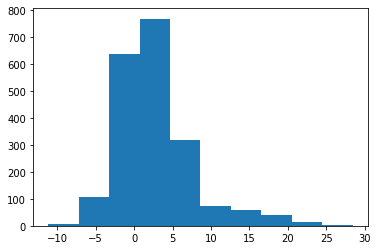

In [9]:
print(len(MFBs), len(MFVs), len(Ps_normalised), len(norm_phot_resids), len(image_SNRs), len(image_FWHMs), len(stamp_ids))
print(np.median(MFBs), np.median(MFVs), np.median(Ps_normalised), np.median(norm_phot_resids), np.median(image_SNRs), np.median(image_FWHMs))
plt.hist(np.array(norm_phot_resids).flatten())
performance_results = np.vstack((MFBs, MFVs, Ps_normalised, np.array(norm_phot_resids).flatten(), image_SNRs, image_FWHMs, stamp_ids)).T
print(performance_results.shape)
#np.savetxt(os.path.join(path,'PyTorch_OGLE_demo_rest.txt'), performance_results)